### Data Preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import mpl_finance
import yfinance as yf

In [3]:
#root_dir = "\\"
approach = ['BB','RSI']
methods = ['BPS','BHPS','BPHS']
str_dir_1 = str()
str_dir_2 = str()

# Pull data from yahoo with a timeline from 1983 1st Jan to - 2021 17th June
ticker = '^GSPC'
df = yf.download(ticker, start = '1983-01-01', end = '2024-03-14')
df.reset_index(inplace=True)

# Save the raw file to CSV
df.to_csv("./stockpred/data/stock_data.csv", index = False)

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Import the scraped data
df = pd.read_csv("./stockpred/data/stock_data.csv")

df = df[['Date','Open','High','Low','Close']]
df = df.rename({'Date':'date','High':'high','Low':'low','Open':'open','Close':'close'},axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
df = df.astype(float)

#### Bollinger band approach

In [5]:
import ta

indicator_bb = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=1.5)

# 상한선, 하한선, SMA 추가
df['sma_20'] = indicator_bb.bollinger_mavg()
df['upper_bb'] = indicator_bb.bollinger_hband()
df['lower_bb'] = indicator_bb.bollinger_lband()

# Function for bb strategy
def implement_bb_approach(data, lower_bb, upper_bb):
    bb_signal = []
    for i in range(len(data)):
        if i == 0:
            # 첫 번째 요소는 비교할 이전 값이 없으므로 넘어갑니다.
            bb_signal.append(0)
            continue
        # 시나리오 1: 현재 가격이 하한선 아래 - 매수 신호
        if data[i] < lower_bb[i]:
            signal = 1
        # 시나리오 2: 현재 가격이 상한선 위 - 매도 신호
        elif data[i] > upper_bb[i]:
            signal = -1
        else:
            signal = 0  # 그 외 경우는 홀드 신호
        bb_signal.append(signal)
    
    return bb_signal

#### RSI Strategy

In [6]:
def implement_rsi_approach(close, window):

    # Price increase or decrease over previous day
    dif = close.diff()
    dif = dif[1:]

    # pos_m identifies stock price going up
    # neg_m udentifies stock price going down
    pos_m, neg_m = dif.copy(), dif.copy()
    pos_m[pos_m < 0] = 0
    neg_m[neg_m > 0] = 0

    # Positive Rolling Mean Exponential
    prme = pos_m.ewm(span=window).mean()
    # Negative Rolling Mean Exponential
    nrme = neg_m.abs().ewm(span=window).mean()

    # Ratio of magnitude of up move to down move
    RSE = prme / nrme
    RSIE = 100.0 - (100.0 / (1.0 + RSE))
    return RSIE

In [7]:
for i in approach:
    # BB
    if i == "BB":
        bb_signal = implement_bb_approach(df['close'], df['lower_bb'], df['upper_bb'])
        bb_signal = pd.DataFrame(bb_signal).rename(columns = {0:'bb_signal'}).set_index(df.index)
        df = df.join(bb_signal, how = 'inner')
        df.reset_index(inplace=True)
        df.to_csv("./stockpred/data/df_bb_out.csv")
        print(df.bb_signal.value_counts(dropna=False))
    # RSI
    else:
        rsi_signal = implement_rsi_approach(df['close'], 14)
        rsi_signal = pd.DataFrame(rsi_signal).rename(columns={'close': 'rsie'})
        df = pd.merge(df, rsi_signal, how='left', left_index=True, right_index=True)
        df.to_csv("./stockpred/data/df_rsi_out.csv")

 0    7135
-1    2072
 1    1177
Name: bb_signal, dtype: int64


In [8]:
df

,date,open,high,low,close,sma_20,upper_bb,lower_bb,bb_signal,rsie
0,1983-01-03,140.649994,141.330002,138.199997,138.339996,NaN,NaN,NaN,0,NaN
1,1983-01-04,138.330002,141.360001,138.080002,141.360001,NaN,NaN,NaN,0,100.000000
2,1983-01-05,141.350006,142.600006,141.149994,141.960007,NaN,NaN,NaN,0,100.000000
3,1983-01-06,142.009995,145.770004,142.009995,145.270004,NaN,NaN,NaN,0,100.000000
4,1983-01-07,145.270004,146.460007,145.149994,145.179993,NaN,NaN,NaN,0,98.325446
...,...,...,...,...,...,...,...,...,...,...
10379,2024-03-07,5132.379883,5165.620117,5128.209961,5157.359863,5054.556421,5139.477241,4969.635600,-1,69.023328
10380,2024-03-08,5164.459961,5189.259766,5117.500000,5123.689941,5060.845410,5146.281074,4975.409746,0,59.262559
10381,2024-03-11,5111.959961,5124.660156,5091.140137,5117.939941,5065.411914,5151.940529,4978.883299,0,57.655965
10382,2024-03-12,5134.299805,5179.870117,5114.479980,5175.270020,5073.083423,5165.273120,4980.893725,-1,67.722643


In [10]:
def plotgraph(start,finish,method,approach,str_dir_1,str_dir_2):
    open = []
    high = []
    low = []
    close = []
    # Get the data from the dataframe
    for x in range(finish - start):
        open.append(float(df.iloc[start][1]))
        high.append(float(df.iloc[start][2]))
        low.append(float(df.iloc[start][3]))
        close.append(float(df.iloc[start][4]))
        start = start + 1
    fig = plt.figure(num=1, figsize=(3, 3), dpi=50, facecolor='w', edgecolor='k')
    dx = fig.add_subplot(111)
    mpl_finance.candlestick2_ochl(dx, open, close, high, low, width=1.5, colorup='g', colordown='r', alpha=0.5)
    plt.autoscale()
    plt.axis('off')

    # BB Approach
    if approach == "BB":
        # Save to separate directories
        if method == "BPS":
        # Buy & Sell
            if df.bb_signal[finish] == 1:
                plt.savefig(str_dir_1 + str(finish) + '.jpg', bbox_inches='tight') #buy
            else:
                plt.savefig(str_dir_2 + str(finish) + '.jpg', bbox_inches='tight') #sell
        # Buy , [Hold + Sell]
        elif method == "BHPS":
            if df.bb_signal[finish] == 1:
                plt.savefig(str_dir_1 + str(finish) + '.jpg', bbox_inches='tight') #buy
            else:
                plt.savefig(str_dir_2 + str(finish) + '.jpg', bbox_inches='tight') #sell + hold
        #[Buy + Hold], Sell
        else:
            if df.bb_signal[finish] == -1:
                plt.savefig(str_dir_2 + str(finish) + '.jpg', bbox_inches='tight') #sell
            else:
                plt.savefig(str_dir_1 + str(finish) + '.jpg', bbox_inches='tight') #buy + hold

    # RSI Approach
    else:
        # Save to separate directories
        if method == "BPS":
            # Buy(<30) & Sell(>70)
            if df.rsie[finish] < 30:
                plt.savefig(str_dir_1 + str(finish) + '.jpg', bbox_inches='tight')  # buy
            else:
                plt.savefig(str_dir_2 + str(finish) + '.jpg', bbox_inches='tight')  # sell

        # Buy(<30) , [Hold + Sell](>=30)
        elif method == "BHPS":
            if df.rsie[finish] < 30:
                plt.savefig(str_dir_1 + str(finish) + '.jpg', bbox_inches='tight')  # buy
            else:
                plt.savefig(str_dir_2 + str(finish) + '.jpg', bbox_inches='tight')  # sell + hold

        # [Buy + Hold](<=70), Sell(>70)
        else:
            if df.rsie[finish] >70:
                plt.savefig(str_dir_2 + str(finish) + '.jpg', bbox_inches='tight')  # sell
            else:
                plt.savefig(str_dir_1 + str(finish) + '.jpg', bbox_inches='tight')  # buy + hold


    open.clear()
    high.clear()
    low.clear()
    close.clear()
    plt.cla()
    plt.clf()

In [9]:
def plotgraph_hold(start,finish,method,approach,str_dir_1,str_dir_2, str_dir_3):
    open = []
    high = []
    low = []
    close = []
    # Get the data from the dataframe
    for x in range(finish - start):
        open.append(float(df.iloc[start][1]))
        high.append(float(df.iloc[start][2]))
        low.append(float(df.iloc[start][3]))
        close.append(float(df.iloc[start][4]))
        start = start + 1
    fig = plt.figure(num=1, figsize=(3, 3), dpi=50, facecolor='w', edgecolor='k')
    dx = fig.add_subplot(111)
    mpl_finance.candlestick2_ochl(dx, open, close, high, low, width=1.5, colorup='g', colordown='r', alpha=0.5)
    plt.autoscale()
    plt.axis('off')

    # BB Approach
    if approach == "BB":
        # Save to separate directories
        if method == "BPS":
        # Buy & Sell
            if df.bb_signal[finish] == 1:
                plt.savefig(str_dir_1 + str(finish) + '.jpg', bbox_inches='tight') #buy
            elif df.bb_signal[finish] == 0:
                plt.savefig(str_dir_3 + str(finish) + '.jpg', bbox_inches='tight') # hold
            else:
                plt.savefig(str_dir_2 + str(finish) + '.jpg', bbox_inches='tight') #sell
        # Buy , [Hold + Sell]
        elif method == "BHPS":
            if df.bb_signal[finish] == 1:
                plt.savefig(str_dir_1 + str(finish) + '.jpg', bbox_inches='tight') #buy
            else:
                plt.savefig(str_dir_2 + str(finish) + '.jpg', bbox_inches='tight') #sell + hold
        #[Buy + Hold], Sell
        else:
            if df.bb_signal[finish] == -1:
                plt.savefig(str_dir_2 + str(finish) + '.jpg', bbox_inches='tight') #sell
            else:
                plt.savefig(str_dir_1 + str(finish) + '.jpg', bbox_inches='tight') #buy + hold

    # RSI Approach
    else:
        # Save to separate directories
        if method == "BPS":
            # Buy(<30) & Sell(>70)
            if df.rsie[finish] < 30:
                plt.savefig(str_dir_1 + str(finish) + '.jpg', bbox_inches='tight')  # buy
            else:
                plt.savefig(str_dir_2 + str(finish) + '.jpg', bbox_inches='tight')  # sell

        # Buy(<30) , [Hold + Sell](>=30)
        elif method == "BHPS":
            if df.rsie[finish] < 30:
                plt.savefig(str_dir_1 + str(finish) + '.jpg', bbox_inches='tight')  # buy
            else:
                plt.savefig(str_dir_2 + str(finish) + '.jpg', bbox_inches='tight')  # sell + hold

        # [Buy + Hold](<=70), Sell(>70)
        else:
            if df.rsie[finish] >70:
                plt.savefig(str_dir_2 + str(finish) + '.jpg', bbox_inches='tight')  # sell
            else:
                plt.savefig(str_dir_1 + str(finish) + '.jpg', bbox_inches='tight')  # buy + hold


    open.clear()
    high.clear()
    low.clear()
    close.clear()
    plt.cla()
    plt.clf()

In [12]:
for i in approach:
    # BB Approach
    if i == "BB":
        # Loop for all the methods
        for j in methods:
            # Buy & Sell
            if j == "BPS":
                str_dir_1 = "./stockpred/bb/str1/train/buy/"
                str_dir_2 = "./stockpred/bb/str1/train/sell/"
                str_dir_3 = "./stockpred/bb/str1/train/hold/"
                for k in range(20,len(df.bb_signal)):
                    # plotgraph(start, finish, method,approach,str_dir_1, str_dir_2):
                    plotgraph_hold(k - 20, k,j,i,str_dir_1, str_dir_2, str_dir_3)
            # Buy and [Hold + Sell]
            elif j == "BHPS":
                str_dir_1 = "./stockpred/bb/str2/train/buy/"
                str_dir_2 = "./stockpred/bb/str2/train/hold_sell/"
                for k in range(20, len(df.bb_signal)):
                    plotgraph(k - 20, k,j,i,str_dir_1, str_dir_2)
            # [Buy + Hold], Sell
            else:
                str_dir_1 = "./stockpred/bb/str3/train/buy_hold/"
                str_dir_2 = "./stockpred/bb/str3/train/sell/"
                for k in range(20, len(df.bb_signal)):
                    plotgraph(k - 20, k,j,i,str_dir_1, str_dir_2)

<Figure size 150x150 with 0 Axes>

KeyboardInterrupt: 

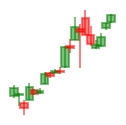

In [11]:
for i in approach:
    # BB Approach
    if i == "BB":
        # Loop for all the methods
        for j in methods:
            # Buy & Sell
            if j == "BPS":
                str_dir_1 = "./stockpred/bb/str1/train/buy/"
                str_dir_2 = "./stockpred/bb/str1/train/sell/"
                
                for k in range(20,len(df.bb_signal)):
                    if df.bb_signal[k] != 0:
                        # plotgraph(start, finish, method,approach,str_dir_1, str_dir_2):
                        plotgraph_hold(k - 20, k,j,i,str_dir_1, str_dir_2, str_dir_3)
            # Buy and [Hold + Sell]
            elif j == "BHPS":
                str_dir_1 = "./stockpred/bb/str2/train/buy/"
                str_dir_2 = "./stockpred/bb/str2/train/hold_sell/"
                for k in range(20, len(df.bb_signal)):
                    plotgraph(k - 20, k,j,i,str_dir_1, str_dir_2)
            # [Buy + Hold], Sell
            else:
                str_dir_1 = "./stockpred/bb/str3/train/buy_hold/"
                str_dir_2 = "./stockpred/bb/str3/train/sell/"
                for k in range(20, len(df.bb_signal)):
                    plotgraph(k - 20, k,j,i,str_dir_1, str_dir_2)
    # RSI Approach
    else:
        # Loop for all the methods
        for j in methods:
            # Buy & Sell
            if j == "BPS":
                str_dir_1 = "./stockpred/rsi/str1/train/buy/"
                str_dir_2 = "./stockpred/rsi/str1/train/sell/"
                for k in range(14,len(df.rsie)):
                    if ((df.rsie[k] < 30) | (df.rsie[k] >70)):
                        plotgraph(k-14,k,j,i,str_dir_1, str_dir_2)
            # Buy and [Hold + Sell]
            elif j == "BHPS":
                str_dir_1 = "./stockpred/rsi/str2/train/buy/"
                str_dir_2 = "./stockpred/rsi/str2/train/hold_sell/"
                for k in range(14,len(df.rsie)):
                    plotgraph(k-14,k,j,i,str_dir_1, str_dir_2)
            # [Buy + Hold], Sell
            else:
                str_dir_1 = "./stockpred/rsi/str3/train/buy_hold/"
                str_dir_2 = "./stockpred/rsi/str3/train/sell/"
                for k in range(14,len(df.rsie)):
                    plotgraph(k-14,k,j,i,str_dir_1, str_dir_2)